In [1]:
import pyspark
import pandas as pd
import numpy as np
spark = pyspark.sql.SparkSession.builder.getOrCreate()
from pyspark.sql.functions import *
from pyspark.sql.functions import lit
from pyspark.sql.functions import regexp_extract, regexp_replace
import re

#### Remember: you have to 'register' a table to query it with spark.sql
- mpg.createOrReplaceTempView("mpg")

In [2]:
pandas_df = pd.read_csv('activities.csv')

In [3]:
pandas_df.head()

,Activity ID,Activity Date,Activity Name,Activity Type,Activity Description,Elapsed Time,Distance,Max Heart Rate,Relative Effort,Commute,...,UV Index,Weather Ozone,"<span class=""translation_missing"" title=""translation missing: en-US.lib.export.portability_exporter.activities.horton_values.jump_count"">Jump Count</span>","<span class=""translation_missing"" title=""translation missing: en-US.lib.export.portability_exporter.activities.horton_values.total_grit"">Total Grit</span>","<span class=""translation_missing"" title=""translation missing: en-US.lib.export.portability_exporter.activities.horton_values.avg_flow"">Avg Flow</span>","<span class=""translation_missing"" title=""translation missing: en-US.lib.export.portability_exporter.activities.horton_values.flagged"">Flagged</span>","<span class=""translation_missing"" title=""translation missing: en-US.lib.export.portability_exporter.activities.horton_values.avg_elapsed_speed"">Avg Elapsed Speed</span>","<span class=""translation_missing"" title=""translation missing: en-US.lib.export.portability_exporter.activities.horton_values.dirt_distance"">Dirt Distance</span>","<span class=""translation_missing"" title=""translation missing: en-US.lib.export.portability_exporter.activities.horton_values.newly_explored_distance"">Newly Explored Distance</span>","<span class=""translation_missing"" title=""translation missing: en-US.lib.export.portability_exporter.activities.horton_values.newly_explored_dirt_distance"">Newly Explored Dirt Distance</span>"
0,350128633,"Jul 20, 2015, 1:06:57 PM",Renecca creek rd,Ride,NaN,2352,13.48,NaN,NaN,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,623600149,"Oct 11, 2015, 10:03:14 PM",Afternoon Ride,Ride,NaN,5495,23.61,NaN,NaN,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,797001969,"Dec 8, 2016, 4:28:12 PM",Morning Ride,Ride,NaN,8,0.03,NaN,NaN,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,800888948,"Dec 12, 2016, 10:22:44 PM",Afternoon Ride,Ride,NaN,7942,10.22,149.0,8.0,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,811340614,"Dec 25, 2016, 10:37:32 PM",Afternoon Ride,Ride,NaN,4983,26.16,162.0,32.0,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
pandas_df['Activity Type'].value_counts()

Ride    344
Run      77
Hike     10
Name: Activity Type, dtype: int64

In [5]:
pandas_df.columns.to_list()

['Activity ID',
 'Activity Date',
 'Activity Name',
 'Activity Type',
 'Activity Description',
 'Elapsed Time',
 'Distance',
 'Max Heart Rate',
 'Relative Effort',
 'Commute',
 'Activity Gear',
 'Filename',
 'Athlete Weight',
 'Bike Weight',
 'Elapsed Time.1',
 'Moving Time',
 'Distance.1',
 'Max Speed',
 'Average Speed',
 'Elevation Gain',
 'Elevation Loss',
 'Elevation Low',
 'Elevation High',
 'Max Grade',
 'Average Grade',
 'Average Positive Grade',
 'Average Negative Grade',
 'Max Cadence',
 'Average Cadence',
 'Max Heart Rate.1',
 'Average Heart Rate',
 'Max Watts',
 'Average Watts',
 'Calories',
 'Max Temperature',
 'Average Temperature',
 'Relative Effort.1',
 'Total Work',
 'Number of Runs',
 'Uphill Time',
 'Downhill Time',
 'Other Time',
 'Perceived Exertion',
 '<span class="translation_missing" title="translation missing: en-US.lib.export.portability_exporter.activities.horton_values.type">Type</span>',
 '<span class="translation_missing" title="translation missing: en-US.l

In [6]:
cols = ['Activity ID',
 'Activity Date',
 'Activity Name',
 'Activity Type',
 'Elapsed Time',
 'Distance',
 'Elapsed Time.1',
 'Moving Time',
 'Distance.1',
 'Max Speed',
 'Average Speed',
 'Elevation Gain',
 'Elevation Loss',
 'Elevation Low',
 'Elevation High',
 'Max Grade',
 'Average Grade',
 'Average Watts',
 'Calories']

In [7]:
pandas_df[cols].isna().sum()

Activity ID         0
Activity Date       0
Activity Name       0
Activity Type       0
Elapsed Time        0
Distance            0
Elapsed Time.1      5
Moving Time         0
Distance.1          0
Max Speed           0
Average Speed     148
Elevation Gain      4
Elevation Loss    155
Elevation Low       0
Elevation High      0
Max Grade           0
Average Grade       0
Average Watts      88
Calories           38
dtype: int64

In [8]:
activities = pandas_df[cols]

In [9]:
activities = activities.rename(columns={'Activity ID':'Activity_ID',
 'Activity Date': 'Activity_date',
 'Activity Name': 'Activity_name',
 'Activity Type': 'Activity_Type',
 'Elapsed Time': 'Elapsed_Time_Secs',
 'Elapsed Time.1':'Elapsed_Time_1',
 'Distance': 'Distance_KM',
 'Moving Time': 'Moving_Time_Secs',
 'Distance.1': 'Distance_Meters',
 'Max Speed':'Max_Speed',
 'Average Speed':'Average_Speed',
 'Elevation Gain': 'Elevation_Gain',
 'Elevation Loss':'Elevation_Loss',
 'Elevation Low':'Elevation_Low',
 'Elevation High':'Elevation_High',
 'Max Grade':'Max_Grade',
 'Average Grade':'Average_Grade',
 'Average Watts':'Average_Watts'})

In [10]:
activities.head().T

,0,1,2,3,4
Activity_ID,350128633,623600149,797001969,800888948,811340614
Activity_date,"Jul 20, 2015, 1:06:57 PM","Oct 11, 2015, 10:03:14 PM","Dec 8, 2016, 4:28:12 PM","Dec 12, 2016, 10:22:44 PM","Dec 25, 2016, 10:37:32 PM"
Activity_name,Renecca creek rd,Afternoon Ride,Morning Ride,Afternoon Ride,Afternoon Ride
Activity_Type,Ride,Ride,Ride,Ride,Ride
Elapsed_Time_Secs,2352,5495,8,7942,4983
Distance_KM,13.48,23.61,0.03,10.22,26.16
Elapsed_Time_1,2352.0,5495.0,8.0,7942.0,4983.0
Moving_Time_Secs,2272.0,3965.0,8.0,1851.0,4424.0
Distance_Meters,13482.599609,23613.199219,30.6,10228.599609,26168.800781
Max_Speed,16.0,15.1,0.2,14.5,15.1


In [11]:
activities.to_csv('activities2.csv')

In [12]:
# df = spark.createDataFrame(pandas_df)


# the usual method is throwing errors related to data types
# some columns have multiple dtypes (NaN, values, etc); giving pyspark issues

In [13]:
df = (spark.read.format("csv").options(header="true")
    .load("activities2.csv"))

In [14]:
df.show(5, vertical=True)

-RECORD 0---------------------------------
 _c0               | 0                    
 Activity_ID       | 350128633            
 Activity_date     | Jul 20, 2015, 1:0... 
 Activity_name     | Renecca creek rd     
 Activity_Type     | Ride                 
 Elapsed_Time_Secs | 2352                 
 Distance_KM       | 13.48                
 Elapsed_Time_1    | 2352.0               
 Moving_Time_Secs  | 2272.0               
 Distance_Meters   | 13482.599609375      
 Max_Speed         | 16.0                 
 Average_Speed     | null                 
 Elevation_Gain    | 187.07899475097656   
 Elevation_Loss    | null                 
 Elevation_Low     | 283.79998779296875   
 Elevation_High    | 406.8999938964844    
 Max_Grade         | 16.799999237060547   
 Average_Grade     | 0.7268630266189575   
 Average_Watts     | null                 
 Calories          | null                 
-RECORD 1---------------------------------
 _c0               | 1                    
 Activity_I

In [15]:
print('DataFrame shape', df.count(), ' x ', len(df.columns))

DataFrame shape 431  x  20


In [16]:
# df.describe().show(vertical = True)

## Note the registration of the df for spark.sql use

In [17]:
df.createOrReplaceTempView("df")

In [18]:
spark.sql(
    """
SELECT Distance_KM, Elapsed_Time_Secs, Distance_KM/(Moving_Time_Secs / 3600) AS Avg_Speed_km_hr
FROM df
"""
).show(5)

+-----------+-----------------+------------------+
|Distance_KM|Elapsed_Time_Secs|   Avg_Speed_km_hr|
+-----------+-----------------+------------------+
|      13.48|             2352|21.359154929577468|
|      23.61|             5495|21.436569987389657|
|       0.03|                8|              13.5|
|      10.22|             7942| 19.87682333873582|
|      26.16|             4983|  21.2875226039783|
+-----------+-----------------+------------------+
only showing top 5 rows



- Strava has some null values in the avrage speepd attribute, which it shouldn't, so I will go back and add as a feature using pyspark

In [19]:
df.columns

['_c0',
 'Activity_ID',
 'Activity_date',
 'Activity_name',
 'Activity_Type',
 'Elapsed_Time_Secs',
 'Distance_KM',
 'Elapsed_Time_1',
 'Moving_Time_Secs',
 'Distance_Meters',
 'Max_Speed',
 'Average_Speed',
 'Elevation_Gain',
 'Elevation_Loss',
 'Elevation_Low',
 'Elevation_High',
 'Max_Grade',
 'Average_Grade',
 'Average_Watts',
 'Calories']

In [20]:
df.select(concat(df.Activity_Type,lit(' '), df.Activity_date)).show(5)

+---------------------------------------+
|concat(Activity_Type,  , Activity_date)|
+---------------------------------------+
|                   Ride Jul 20, 2015...|
|                   Ride Oct 11, 2015...|
|                   Ride Dec 8, 2016,...|
|                   Ride Dec 12, 2016...|
|                   Ride Dec 25, 2016...|
+---------------------------------------+
only showing top 5 rows



In [21]:
df.select(df.Activity_date).show(5, truncate = False)

+-------------------------+
|Activity_date            |
+-------------------------+
|Jul 20, 2015, 1:06:57 PM |
|Oct 11, 2015, 10:03:14 PM|
|Dec 8, 2016, 4:28:12 PM  |
|Dec 12, 2016, 10:22:44 PM|
|Dec 25, 2016, 10:37:32 PM|
+-------------------------+
only showing top 5 rows



In [22]:
# regexp_extract(col('Notes'), '(.)(by)(\s+)(\w+)', 4))
# '.by\s+(\w+)', 1
# r"^(\w{3})(\s)(,)(\d{4})",1

In [23]:
df.select(
    "Activity_Type",
    regexp_extract("Activity_Date", r"^(\w{3})", 1).alias("Month"),
    regexp_extract("Activity_Date", r"^\w{3}\s\d{1,2}(,)\s(.{4})",2).alias("Year"),
).show(5,truncate=False)

+-------------+-----+----+
|Activity_Type|Month|Year|
+-------------+-----+----+
|Ride         |Jul  |2015|
|Ride         |Oct  |2015|
|Ride         |Dec  |2016|
|Ride         |Dec  |2016|
|Ride         |Dec  |2016|
+-------------+-----+----+
only showing top 5 rows



- ok, you got the year.  why is it group 2 though? regex.

In [24]:
# the answer to my question on stackoverflow : )


from pyspark.sql import functions as F

df1 = (df.withColumn("Activity_date", F.to_timestamp("Activity_date", "MMM d, yyyy, h:mm:ss a"))
       .withColumn("Month", F.date_format("Activity_date", "MMM"))
       .withColumn("Year", F.year("Activity_date"))
       )

df1.show(vertical=True)

-RECORD 0--------------------------------
 _c0               | 0                   
 Activity_ID       | 350128633           
 Activity_date     | 2015-07-20 13:06:57 
 Activity_name     | Renecca creek rd    
 Activity_Type     | Ride                
 Elapsed_Time_Secs | 2352                
 Distance_KM       | 13.48               
 Elapsed_Time_1    | 2352.0              
 Moving_Time_Secs  | 2272.0              
 Distance_Meters   | 13482.599609375     
 Max_Speed         | 16.0                
 Average_Speed     | null                
 Elevation_Gain    | 187.07899475097656  
 Elevation_Loss    | null                
 Elevation_Low     | 283.79998779296875  
 Elevation_High    | 406.8999938964844   
 Max_Grade         | 16.799999237060547  
 Average_Grade     | 0.7268630266189575  
 Average_Watts     | null                
 Calories          | null                
 Month             | Jul                 
 Year              | 2015                
-RECORD 1-------------------------

In [25]:
example = "Jul 20, 2015, 1:06:57 PM"

In [26]:
re.search(r"^\w{3}", example)

<re.Match object; span=(0, 3), match='Jul'>

In [27]:
re.search(r"^\w{3}\s\d{1,2}", example)

<re.Match object; span=(0, 6), match='Jul 20'>

In [28]:
re.search(r"^\w{3}\s\d{1,2}(,)", example)

<re.Match object; span=(0, 7), match='Jul 20,'>

In [29]:
re.search(r"^\w{3}\s\d{1,2}(,)\s(.{4})", example)

<re.Match object; span=(0, 12), match='Jul 20, 2015'>

In [30]:
df.filter(df.Distance_KM > 80).show(5, vertical=True)

-RECORD 0---------------------------------
 _c0               | 176                  
 Activity_ID       | 3753411577           
 Activity_date     | Jul 12, 2020, 3:0... 
 Activity_name     | Morning Ride         
 Activity_Type     | Ride                 
 Elapsed_Time_Secs | 16873                
 Distance_KM       | 82.52                
 Elapsed_Time_1    | 16873.0              
 Moving_Time_Secs  | 13586.0              
 Distance_Meters   | 82523.8984375        
 Max_Speed         | 13.600000381469728   
 Average_Speed     | 6.0741868019104      
 Elevation_Gain    | 505.89007568359375   
 Elevation_Loss    | 505.8900146484375    
 Elevation_Low     | 200.0                
 Elevation_High    | 319.20001220703125   
 Max_Grade         | 22.600000381469727   
 Average_Grade     | 0.0                  
 Average_Watts     | 146.6240692138672    
 Calories          | 2221.117431640625    
-RECORD 1---------------------------------
 _c0               | 194                  
 Activity_I

In [31]:
df.filter(df.Distance_KM < 10).where(df.Activity_Type == 'Ride').show(5, vertical=True)

-RECORD 0---------------------------------
 _c0               | 2                    
 Activity_ID       | 797001969            
 Activity_date     | Dec 8, 2016, 4:28... 
 Activity_name     | Morning Ride         
 Activity_Type     | Ride                 
 Elapsed_Time_Secs | 8                    
 Distance_KM       | 0.03                 
 Elapsed_Time_1    | 8.0                  
 Moving_Time_Secs  | 8.0                  
 Distance_Meters   | 30.600000381469727   
 Max_Speed         | 0.2000000029802322   
 Average_Speed     | null                 
 Elevation_Gain    | 0.0                  
 Elevation_Loss    | null                 
 Elevation_Low     | 207.8999938964844    
 Elevation_High    | 207.8999938964844    
 Max_Grade         | 0.0                  
 Average_Grade     | 0.0                  
 Average_Watts     | 0.0                  
 Calories          | null                 
-RECORD 1---------------------------------
 _c0               | 6                    
 Activity_I

In [32]:
df.select(df.Distance_KM,when(df.Distance_KM > 80, 'Long Ride')
          .otherwise("Less Long")
          .alias('Ride_Length')
         ).where(df.Distance_KM > 50).show(20)
#I added a where statement to narrow the results a little and actually see 
# some long rides.
# There are fewer than 20 total in the filter

+-----------+-----------+
|Distance_KM|Ride_Length|
+-----------+-----------+
|      56.76|  Less Long|
|      76.13|  Less Long|
|      52.48|  Less Long|
|      82.52|  Long Ride|
|      97.52|  Long Ride|
|      84.81|  Long Ride|
|      119.4|  Long Ride|
|      57.08|  Less Long|
|     161.35|  Long Ride|
|      79.74|  Less Long|
|      51.85|  Less Long|
|      57.85|  Less Long|
|      54.51|  Less Long|
|      58.85|  Less Long|
+-----------+-----------+



In [33]:
df.select(df.Distance_KM, 
         (when(df.Distance_KM<10,'very short')
         .when(df.Distance_KM<25,'short')
         .when(df.Distance_KM<50,'medium')
         .when(df.Distance_KM<80,'long')
         .otherwise('very long')
         .alias('Ride_Length'))
         ).where(df.Activity_Type=='Ride').show(50)

+-----------+-----------+
|Distance_KM|Ride_Length|
+-----------+-----------+
|      13.48|      short|
|      23.61|      short|
|       0.03| very short|
|      10.22|      short|
|      26.16|     medium|
|      12.25|      short|
|       9.82| very short|
|      37.42|     medium|
|      47.55|     medium|
|       5.49| very short|
|       3.69| very short|
|      28.42|     medium|
|      18.62|      short|
|      33.63|     medium|
|      16.09|      short|
|      48.86|     medium|
|      16.74|      short|
|      46.25|     medium|
|        6.4| very short|
|      18.31|      short|
|      50.69|       long|
|      56.76|       long|
|      35.21|     medium|
|      32.32|     medium|
|      11.97|      short|
|      37.74|     medium|
|      76.13|       long|
|       36.8|     medium|
|       5.07| very short|
|      30.49|     medium|
|      46.69|     medium|
|      24.74|      short|
|       5.41| very short|
|      35.51|     medium|
|      11.34|      short|
|      17.63

In [34]:
df.columns

['_c0',
 'Activity_ID',
 'Activity_date',
 'Activity_name',
 'Activity_Type',
 'Elapsed_Time_Secs',
 'Distance_KM',
 'Elapsed_Time_1',
 'Moving_Time_Secs',
 'Distance_Meters',
 'Max_Speed',
 'Average_Speed',
 'Elevation_Gain',
 'Elevation_Loss',
 'Elevation_Low',
 'Elevation_High',
 'Max_Grade',
 'Average_Grade',
 'Average_Watts',
 'Calories']

In [35]:
df.select(df.Distance_KM, df.Elapsed_Time_Secs).withColumn("Avg_Speed_KM_per_Hr", \
                    col('Distance_KM') / (col('Elapsed_Time_Secs')/3600)).show()

+-----------+-----------------+-------------------+
|Distance_KM|Elapsed_Time_Secs|Avg_Speed_KM_per_Hr|
+-----------+-----------------+-------------------+
|      13.48|             2352|  20.63265306122449|
|      23.61|             5495| 15.467879890809828|
|       0.03|                8|               13.5|
|      10.22|             7942|  4.632586250314783|
|      26.16|             4983|   18.8994581577363|
|      12.25|            11270| 3.9130434782608696|
|       9.82|             8235|  4.292896174863388|
|      37.42|             9322| 14.450976185367946|
|      47.55|            14725| 11.625127334465194|
|       5.49|             2365|  8.356871035940804|
|       3.69|             1272| 10.443396226415095|
|      28.42|             6665| 15.350637659414854|
|      18.62|           267771|0.25033330719159286|
|      33.63|            17863|  6.777584952135699|
|      16.09|            15660|  3.698850574712644|
|      48.86|            15832| 11.110156644770086|
|      16.74

In [36]:
df.select(df.Distance_KM, df.Elapsed_Time_Secs).withColumn("Avg_Speed_KM_per_Hr", \
col('Distance_KM') / (col('Elapsed_Time_Secs')/3600)).sort(desc('Avg_Speed_KM_per_Hr'))\
.show()

+-----------+-----------------+-------------------+
|Distance_KM|Elapsed_Time_Secs|Avg_Speed_KM_per_Hr|
+-----------+-----------------+-------------------+
|      46.26|             5975| 27.872133891213387|
|      40.51|             5333|  27.34595912244515|
|      39.02|             5182| 27.107680432265536|
|      44.31|             6179| 25.815827803851757|
|      25.47|             3630| 25.259504132231406|
|      38.49|             5555| 24.944014401440143|
|      23.69|             3464|  24.62009237875289|
|      26.28|             3873| 24.427575522850503|
|      28.78|             4252|  24.36688617121355|
|       6.27|              934| 24.167023554603855|
|      26.02|             3892| 24.067831449126412|
|      28.62|             4285|  24.04480746791132|
|      32.41|             4878|  23.91881918819188|
|       7.32|             1104| 23.869565217391308|
|       38.9|             5914| 23.679404802164356|
|      39.35|             5985| 23.669172932330827|
|      25.88

- Great use of sort()

In [37]:
df.select(
    df.Distance_KM, 
         (
             when(df.Distance_KM<10,'very short')
         .when(df.Distance_KM<25,'short')
         .when(df.Distance_KM<50,'medium')
         .when(df.Distance_KM<80,'long')
         .otherwise('very long')
         .alias('Ride_Length')
         )
    ,df.Elapsed_Time_Secs)\
    .withColumn("Avg_Speed_KM_per_Hr",
                col('Distance_KM') / (col('Elapsed_Time_Secs')/3600))\
    .sort(asc('Ride_Length'))\
    .sort(desc('Avg_Speed_KM_per_Hr'))\
    .where(df.Activity_Type=='Ride').show(20)

+-----------+-----------+-----------------+-------------------+
|Distance_KM|Ride_Length|Elapsed_Time_Secs|Avg_Speed_KM_per_Hr|
+-----------+-----------+-----------------+-------------------+
|      46.26|     medium|             5975| 27.872133891213387|
|      40.51|     medium|             5333|  27.34595912244515|
|      39.02|     medium|             5182| 27.107680432265536|
|      44.31|     medium|             6179| 25.815827803851757|
|      25.47|     medium|             3630| 25.259504132231406|
|      38.49|     medium|             5555| 24.944014401440143|
|      23.69|      short|             3464|  24.62009237875289|
|      26.28|     medium|             3873| 24.427575522850503|
|      28.78|     medium|             4252|  24.36688617121355|
|       6.27| very short|              934| 24.167023554603855|
|      26.02|     medium|             3892| 24.067831449126412|
|      28.62|     medium|             4285|  24.04480746791132|
|      32.41|     medium|             48

- not sure it's possible to groupBy then sort
- maybe by using .agg()?

In [38]:
df.select(
    df.Distance_KM, 
         (
             when(df.Distance_KM<10,'very short')
         .when(df.Distance_KM<25,'short')
         .when(df.Distance_KM<50,'medium')
         .when(df.Distance_KM<80,'long')
         .otherwise('very long')
         .alias('Ride_Length')
         )
    ,df.Elapsed_Time_Secs)\
    .withColumn("Avg_Speed_KM_per_Hr",
                col('Distance_KM') / (col('Elapsed_Time_Secs')/3600))\
    .orderBy('Ride_Length',desc('Avg_Speed_KM_per_Hr'))\
    .where(col('Ride_Length')=='very long').show()

+-----------+-----------+-----------------+-------------------+
|Distance_KM|Ride_Length|Elapsed_Time_Secs|Avg_Speed_KM_per_Hr|
+-----------+-----------+-----------------+-------------------+
|     161.35|  very long|            28995| 20.033109156751163|
|      119.4|  very long|            23464| 18.319127173542448|
|      82.52|  very long|            16873|   17.6063533455817|
|      97.52|  very long|            20592|  17.04895104895105|
|      84.81|  very long|            18190| 16.784826827927432|
+-----------+-----------+-----------------+-------------------+



## Finally got it--remember to define the two arguments in the orderBy()

# also, is this calculating correctly? bc my strava avg speed is 14.5 mph (20 km/hr is only 12.5 mph)

In [39]:
df.select(
    df.Distance_KM, 
         (
             when(df.Distance_KM<10,'very short')
         .when(df.Distance_KM<25,'short')
         .when(df.Distance_KM<50,'medium')
         .when(df.Distance_KM<80,'long')
         .otherwise('very long')
         .alias('Ride_Length')
         )
    ,df.Elapsed_Time_Secs)\
    .withColumn("Avg_Speed_KM_per_Hr",
                col('Distance_KM') / (col('Elapsed_Time_Secs')/3600))\
    .rollup('Ride_Length').count().sort('Ride_Length').show()

+-----------+-----+
|Ride_Length|count|
+-----------+-----+
|       null|  431|
|       long|   12|
|     medium|  122|
|      short|   88|
|  very long|    5|
| very short|  204|
+-----------+-----+



## `rollup` showing the count of ride lengths...where are the nulls coming from?
## oh, that's an aspect of .rollup() duh

In [40]:
df.select(
    df.Distance_KM, 
         (
             when(df.Distance_KM<10,'very short')
         .when(df.Distance_KM<25,'short')
         .when(df.Distance_KM<50,'medium')
         .when(df.Distance_KM<80,'long')
         .otherwise('very long')
         .alias('Ride_Length')
         )
    ,df.Elapsed_Time_Secs)\
    .withColumn("Avg_Speed_KM_per_Hr",
                col('Distance_KM') / (col('Elapsed_Time_Secs')/3600))\
    .withColumn('Speed_Category',
             when(col('Avg_Speed_KM_per_Hr')<10,'slow')
         .when(col('Avg_Speed_KM_per_Hr')<15,'medium')
         .otherwise('fast')
         .alias('Ride_Speed')
         ).where(df.Activity_Type=='Ride').show(20)

+-----------+-----------+-----------------+-------------------+--------------+
|Distance_KM|Ride_Length|Elapsed_Time_Secs|Avg_Speed_KM_per_Hr|Speed_Category|
+-----------+-----------+-----------------+-------------------+--------------+
|      13.48|      short|             2352|  20.63265306122449|          fast|
|      23.61|      short|             5495| 15.467879890809828|          fast|
|       0.03| very short|                8|               13.5|        medium|
|      10.22|      short|             7942|  4.632586250314783|          slow|
|      26.16|     medium|             4983|   18.8994581577363|          fast|
|      12.25|      short|            11270| 3.9130434782608696|          slow|
|       9.82| very short|             8235|  4.292896174863388|          slow|
|      37.42|     medium|             9322| 14.450976185367946|        medium|
|      47.55|     medium|            14725| 11.625127334465194|        medium|
|       5.49| very short|             2365|  8.35687

In [41]:
rides_df = df.select(
    df.Distance_KM, 
         (
             when(df.Distance_KM<10,'very short')
         .when(df.Distance_KM<25,'short')
         .when(df.Distance_KM<50,'medium')
         .when(df.Distance_KM<80,'long')
         .otherwise('very long')
         .alias('Ride_Length')
         )
    ,df.Elapsed_Time_Secs)\
    .withColumn("Avg_Speed_KM_per_Hr",
                col('Distance_KM') / (col('Elapsed_Time_Secs')/3600))\
    .withColumn('Speed_Category',
             when(col('Avg_Speed_KM_per_Hr')<10,'slow')
         .when(col('Avg_Speed_KM_per_Hr')<15,'medium')
         .otherwise('fast')
         .alias('Ride_Speed')
         ).where(df.Activity_Type=='Ride')

In [42]:
rides_df.show(5)

+-----------+-----------+-----------------+-------------------+--------------+
|Distance_KM|Ride_Length|Elapsed_Time_Secs|Avg_Speed_KM_per_Hr|Speed_Category|
+-----------+-----------+-----------------+-------------------+--------------+
|      13.48|      short|             2352|  20.63265306122449|          fast|
|      23.61|      short|             5495| 15.467879890809828|          fast|
|       0.03| very short|                8|               13.5|        medium|
|      10.22|      short|             7942|  4.632586250314783|          slow|
|      26.16|     medium|             4983|   18.8994581577363|          fast|
+-----------+-----------+-----------------+-------------------+--------------+
only showing top 5 rows



In [43]:
rides_df.crosstab('Ride_Length','Speed_Category').show()

+--------------------------+----+------+----+
|Ride_Length_Speed_Category|fast|medium|slow|
+--------------------------+----+------+----+
|                very short|  87|    16|  20|
|                     short|  21|     9|  53|
|                    medium|  68|    25|  28|
|                      long|   3|     4|   5|
|                 very long|   5|     0|   0|
+--------------------------+----+------+----+



- ther's a problem here... the sum of the 'very short' rides isn't high enough
- never mind, this is grouped by rides only

In [44]:
87+17+20+21+9+54+68+25+28+3+4+5+ 5

346

In [45]:
rides_df.rollup('Speed_Category').count().sort('Speed_Category').show()

+--------------+-----+
|Speed_Category|count|
+--------------+-----+
|          null|  344|
|          fast|  184|
|        medium|   54|
|          slow|  106|
+--------------+-----+



- where are the rest of the rides? 
- ah, this is only looking at rides, not runs/hikes.

In [46]:
rides_df.columns

['Distance_KM',
 'Ride_Length',
 'Elapsed_Time_Secs',
 'Avg_Speed_KM_per_Hr',
 'Speed_Category']

In [47]:
rides_df.groupby("Ride_Length").pivot("Speed_Category").mean('Avg_Speed_KM_per_Hr').show()


+-----------+------------------+------------------+-----------------+
|Ride_Length|              fast|            medium|             slow|
+-----------+------------------+------------------+-----------------+
|  very long|17.958473510550757|              null|             null|
| very short|19.477119483049137|13.299678598311173|4.010320854317576|
|       long|18.642844104480854|11.772288964131626|8.699570782786799|
|     medium|21.134622232827326|12.291203435294596|6.983821414291779|
|      short| 19.69496727921184|12.022249888838255| 5.59730022667883|
+-----------+------------------+------------------+-----------------+



In [48]:
rides_df

DataFrame[Distance_KM: string, Ride_Length: string, Elapsed_Time_Secs: string, Avg_Speed_KM_per_Hr: double, Speed_Category: string]

In [49]:
# import pyspark.pandas as ps
rides_pandas = rides_df.toPandas()

In [50]:
rides_pandas.head()

,Distance_KM,Ride_Length,Elapsed_Time_Secs,Avg_Speed_KM_per_Hr,Speed_Category
0,13.48,short,2352,20.632653,fast
1,23.61,short,5495,15.467880,fast
2,0.03,very short,8,13.500000,medium
3,10.22,short,7942,4.632586,slow
4,26.16,medium,4983,18.899458,fast


In [51]:
rides_pandas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344 entries, 0 to 343
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Distance_KM          344 non-null    object 
 1   Ride_Length          344 non-null    object 
 2   Elapsed_Time_Secs    344 non-null    object 
 3   Avg_Speed_KM_per_Hr  343 non-null    float64
 4   Speed_Category       344 non-null    object 
dtypes: float64(1), object(4)
memory usage: 13.6+ KB


In [52]:
all_activities = pd.read_csv('activities2.csv')

In [53]:
all_activities.head()

,Unnamed: 0,Activity_ID,Activity_date,Activity_name,Activity_Type,Elapsed_Time_Secs,Distance_KM,Elapsed_Time_1,Moving_Time_Secs,Distance_Meters,Max_Speed,Average_Speed,Elevation_Gain,Elevation_Loss,Elevation_Low,Elevation_High,Max_Grade,Average_Grade,Average_Watts,Calories
0,0,350128633,"Jul 20, 2015, 1:06:57 PM",Renecca creek rd,Ride,2352,13.48,2352.0,2272.0,13482.599609,16.0,NaN,187.078995,NaN,283.799988,406.899994,16.799999,0.726863,NaN,NaN
1,1,623600149,"Oct 11, 2015, 10:03:14 PM",Afternoon Ride,Ride,5495,23.61,5495.0,3965.0,23613.199219,15.1,NaN,213.251999,NaN,283.799988,407.500000,19.900000,0.000000,150.570999,NaN
2,2,797001969,"Dec 8, 2016, 4:28:12 PM",Morning Ride,Ride,8,0.03,8.0,8.0,30.600000,0.2,NaN,0.000000,NaN,207.899994,207.899994,0.000000,0.000000,0.000000,NaN
3,3,800888948,"Dec 12, 2016, 10:22:44 PM",Afternoon Ride,Ride,7942,10.22,7942.0,1851.0,10228.599609,14.5,NaN,47.843739,NaN,208.000000,235.699997,23.799999,-0.004888,115.796242,238.987305
4,4,811340614,"Dec 25, 2016, 10:37:32 PM",Afternoon Ride,Ride,4983,26.16,4983.0,4424.0,26168.800781,15.1,NaN,73.213295,NaN,194.000000,244.600006,22.400000,-0.009171,121.938919,NaN


In [54]:
test = all_activities[all_activities.Distance_KM > 150]

In [55]:
test.columns

Index(['Unnamed: 0', 'Activity_ID', 'Activity_date', 'Activity_name',
       'Activity_Type', 'Elapsed_Time_Secs', 'Distance_KM', 'Elapsed_Time_1',
       'Moving_Time_Secs', 'Distance_Meters', 'Max_Speed', 'Average_Speed',
       'Elevation_Gain', 'Elevation_Loss', 'Elevation_Low', 'Elevation_High',
       'Max_Grade', 'Average_Grade', 'Average_Watts', 'Calories'],
      dtype='object')

In [56]:
(test.Moving_Time_Secs/3600)/(test.Distance_KM)

254    0.042878
dtype: float64

In [57]:
(test.Distance_KM)/(test.Moving_Time_Secs/3600)

254    23.322091
dtype: float64

- This isn't as fast as my strava average mph (which was 14.5--this is 12.5)
### Ok, this is now correct, don't forget to use Moving Time, not Elapsed Time

In [58]:
test.Average_Speed

254    6.478395
Name: Average_Speed, dtype: float64

- what are the units here??

In [59]:
test

,Unnamed: 0,Activity_ID,Activity_date,Activity_name,Activity_Type,Elapsed_Time_Secs,Distance_KM,Elapsed_Time_1,Moving_Time_Secs,Distance_Meters,Max_Speed,Average_Speed,Elevation_Gain,Elevation_Loss,Elevation_Low,Elevation_High,Max_Grade,Average_Grade,Average_Watts,Calories
254,254,5121359409,"Apr 13, 2021, 10:40:59 AM",My first century,Ride,28995,161.35,28995.0,24906.0,161350.90625,12.4,6.478395,630.592529,630.592529,148.399994,339.100006,19.4,0.0,106.518929,2958.050781


In [61]:
mps = test.Distance_Meters/test.Moving_Time_Secs

### ok this is meters per second

In [62]:
mps*3600/1000

254    23.322222
dtype: float64

In [63]:
import seaborn as sns

In [64]:
# train = train.resample('D').mean()
# create a categorical feature
all_activities['dist_bin'] = pd.cut(all_activities.Distance_KM, \
[-1,10,25,50,80,200],labels=['very_short','short','medium','long','very_long'])

In [65]:
all_activities.groupby('dist_bin').mean()

,Unnamed: 0,Activity_ID,Elapsed_Time_Secs,Distance_KM,Elapsed_Time_1,Moving_Time_Secs,Distance_Meters,Max_Speed,Average_Speed,Elevation_Gain,Elevation_Loss,Elevation_Low,Elevation_High,Max_Grade,Average_Grade,Average_Watts,Calories
dist_bin,,,,,,,,,,,,,,,,,
very_short,241.191176,4.281960e+09,5233.112745,5.994412,5233.112745,1523.691176,5998.363478,8.325972,5.436808,32.257696,31.479574,213.932352,238.407354,9.807090,0.016873,105.296876,314.717621
short,195.352273,3.877562e+09,87145.863636,18.114886,88075.827586,4185.136364,18118.858776,14.312282,4.947746,130.836665,150.508076,306.214772,360.947728,16.108451,0.006883,115.358920,565.203168
medium,185.967213,3.760229e+09,10065.262295,33.573852,10163.237288,6102.360656,33577.373687,13.969689,5.755281,176.621158,181.561392,182.174590,244.398360,15.970913,0.011585,126.032488,832.260760
long,207.833333,4.088899e+09,18815.083333,58.063333,18815.083333,11026.166667,58066.705404,14.431771,4.931691,246.148858,268.390322,138.008335,200.333332,17.768936,-0.000123,109.295998,1329.612177
very_long,217.800000,4.538981e+09,21622.800000,109.120000,21622.800000,17481.800000,109123.120313,14.280000,6.207128,507.218689,507.178668,168.179999,307.520004,17.720000,0.000040,119.008904,2284.646265


In [66]:
all_activities.groupby('dist_bin').count()

,Unnamed: 0,Activity_ID,Activity_date,Activity_name,Activity_Type,Elapsed_Time_Secs,Distance_KM,Elapsed_Time_1,Moving_Time_Secs,Distance_Meters,Max_Speed,Average_Speed,Elevation_Gain,Elevation_Loss,Elevation_Low,Elevation_High,Max_Grade,Average_Grade,Average_Watts,Calories
dist_bin,,,,,,,,,,,,,,,,,,,,
very_short,204,204,204,204,204,204,204,204,204,204,204,122,204,122,204,204,204,204,123,183
short,88,88,88,88,88,88,88,87,88,88,88,61,87,59,88,88,88,88,82,82
medium,122,122,122,122,122,122,122,118,122,122,122,86,119,81,122,122,122,122,121,113
long,12,12,12,12,12,12,12,12,12,12,12,9,12,9,12,12,12,12,12,10
very_long,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5


<AxesSubplot:xlabel='dist_bin', ylabel='Count'>

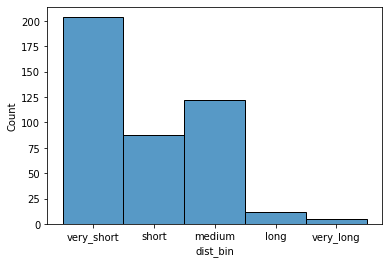

In [67]:
sns.histplot(data=all_activities,x='dist_bin')#,y= count(all_activities.dist_bin))

<AxesSubplot:xlabel='dist_bin', ylabel='Count'>

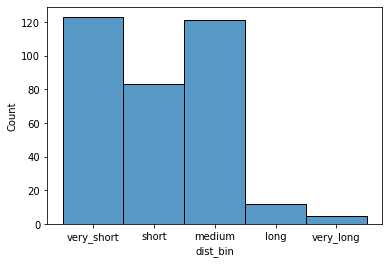

In [68]:
sns.histplot(data=(all_activities[all_activities.Activity_Type == 'Ride']),x='dist_bin')#,y= count(all_activities.dist_bin))

<AxesSubplot:xlabel='dist_bin', ylabel='Count'>

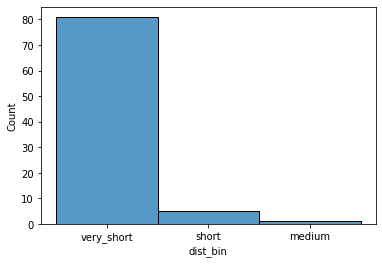

In [70]:
sns.histplot(data=(all_activities[all_activities.Activity_Type != 'Ride']),x='dist_bin')#,y= count(all_activities.dist_bin))

- oh my, there is a "medium" lenght hike or run in there somewhere

In [74]:
not_rides = all_activities[all_activities.Activity_Type != 'Ride']

In [75]:
not_rides[not_rides.Distance_KM>30]

,Unnamed: 0,Activity_ID,Activity_date,Activity_name,Activity_Type,Elapsed_Time_Secs,Distance_KM,Elapsed_Time_1,Moving_Time_Secs,Distance_Meters,...,Average_Speed,Elevation_Gain,Elevation_Loss,Elevation_Low,Elevation_High,Max_Grade,Average_Grade,Average_Watts,Calories,dist_bin
188,188,3955855878,"Aug 23, 2020, 2:51:26 PM",Morning Hike,Hike,9478,31.19,9478.0,5636.0,31198.0,...,5.535486,133.768646,134.768646,176.100006,232.199997,7.1,-0.003205,NaN,3564.387939,medium


- This looks like the hike I did in the Santa Fe National Forest
- Or not, bc there was much more elevation gain on that hike
- aha, this was mis-identified as a hike when it was actually a ride

In [78]:
test2 = not_rides[not_rides.Distance_KM>30]

In [79]:
test2.Activity_Type

188    Hike
Name: Activity_Type, dtype: object

In [91]:
test2.Activity_Type.replace(to_replace='Hike',value='Ride', inplace=True)

/usr/local/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:4509: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(


In [92]:
test2.Activity_Type

188    Ride
Name: Ride, dtype: object

In [94]:
not_rides[not_rides.Distance_KM>15]

,Unnamed: 0,Activity_ID,Activity_date,Activity_name,Activity_Type,Elapsed_Time_Secs,Distance_KM,Elapsed_Time_1,Moving_Time_Secs,Distance_Meters,...,Average_Speed,Elevation_Gain,Elevation_Loss,Elevation_Low,Elevation_High,Max_Grade,Average_Grade,Average_Watts,Calories,dist_bin
185,185,3865421967,"Aug 4, 2020, 5:02:15 PM",Lunch Hike,Hike,19509,16.45,19509.0,15604.0,16456.800781,...,1.054653,666.323730,662.623779,3128.500000,3472.600098,50.000000,0.022483,NaN,1880.198120,short
188,188,3955855878,"Aug 23, 2020, 2:51:26 PM",Morning Hike,Hike,9478,31.19,9478.0,5636.0,31198.000000,...,5.535486,133.768646,134.768646,176.100006,232.199997,7.100000,-0.003205,NaN,3564.387939,medium
224,224,4643712319,"Jan 18, 2021, 4:58:01 PM",Morning Hike,Hike,18369,24.54,18369.0,16877.0,24545.699219,...,1.454388,146.728790,146.928787,61.200001,99.599998,10.800000,-0.000815,NaN,2804.359131,short
227,227,4714540882,"Jan 31, 2021, 4:32:54 PM",Morning Hike,Hike,16513,19.10,16513.0,15681.0,19108.500000,...,1.218577,410.475983,428.475983,548.700012,695.400024,49.599998,-0.094199,NaN,2183.156250,short
228,228,4747311579,"Feb 6, 2021, 4:16:59 PM",Lunch Hike,Hike,15739,20.92,15739.0,11211.0,20927.199219,...,1.866667,2056.818604,2070.518555,2458.000000,2753.000000,49.900002,-0.065465,NaN,2390.943604,short
